El objetivo de este notebook es contar de manera automática los diferentes elementos (células) que aparecen en las dos imágenes proporcionadas

Para leer y cargar la imagen

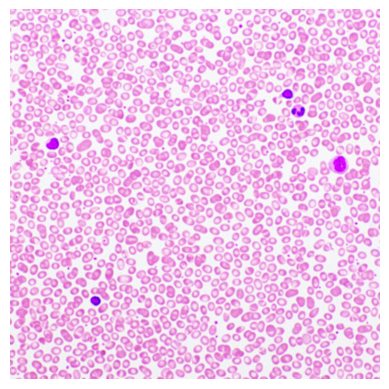

In [2]:
# Se importan algunas de las librerías necesarias para abrir el archivo
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Se especifica la ruta de la imagen en Google Colab
img_path = '/content/celulas.jpg'

# Se carga y muestra la imagen
img = mpimg.imread(img_path) # Para obtener la ruta de la imagen
imgplot = plt.imshow(img) # Para mostrar la imagen
plt.axis('off')  # Para quitar los ejes
plt.show() # Para mostrar la imagen por pantalla

In [3]:
img.shape # Para conocer el tamaño de la imagen

(880, 880, 3)

In [4]:
_,__, capas = img.shape # De aquí ahora mismo solamente nos interesa el número de capas
print('Capas: '+str(capas)) #para ver de cuántas capas está formado

Capas: 3


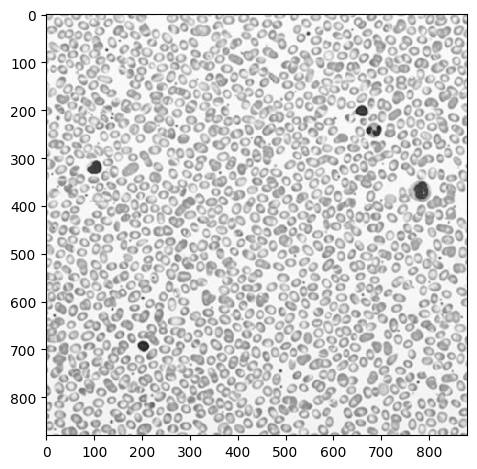

In [5]:
from skimage import color # Carga las librerías
from skimage import color, io
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk
import numpy as np
from skimage.measure import find_contours
from skimage.draw import polygon

# Convierte a escala de grises
gray_image = color.rgb2gray(img)

io.imshow(gray_image) #Muestra la imagen
io.show() #Muestra la imagen por pantalla

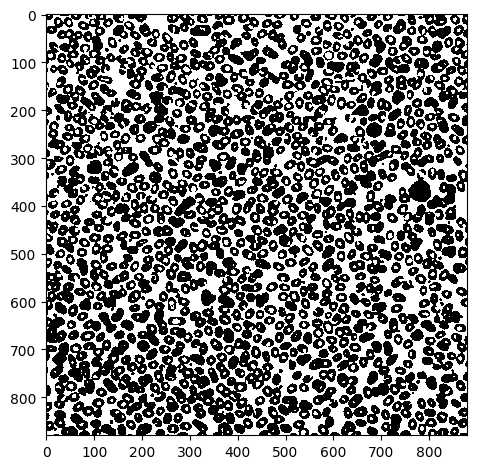

In [6]:
# Aplicando un threshold o umbralización para obtener en negro las células y en blanco el fondo y huecos. Facilita la segmentación.

from skimage import color, filters

# Apply global binary thresholding
threshold_value = 0.85 #este valor ha sido ajustado
binary_mask = gray_image > threshold_value #Se queda con los valores de la imagen que están por encima del umbral

# Se muestra la imagen por la pantalla
io.imshow(binary_mask)
io.show()

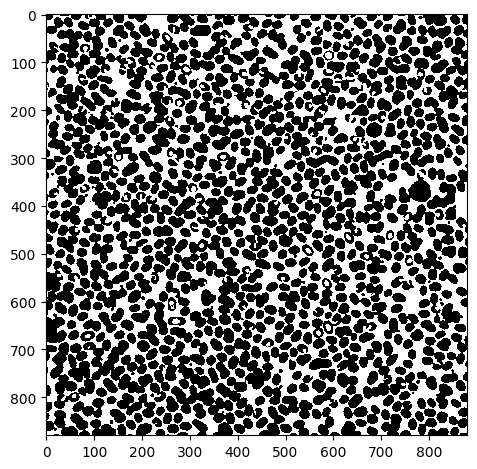

In [7]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
from skimage import io
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk
import numpy as np
from skimage.measure import find_contours
from skimage.draw import polygon

# Quitamos los objetos muy pequeños
binary_mask = remove_small_objects(binary_mask, min_size=90)  # Adjust min_size as needed

# Eliminamos los circulos blancos pequeños (que son los que se encuentran dentro de las células)
# Y ajustamos el tamaño mínimo del objeto para remover, este parámetro se ha ido ajustando y modificando para obtener mejores resultados
binary_mask_cleaned = remove_small_objects(binary_mask, min_size=90)

# Vemos la máscara limpia
io.imshow(binary_mask_cleaned)
io.show()


Podemos observar que hay un menor número de círculos blancos en el interior de las células, lo cual facilitará su lectura.

Observamos que el espacio resultante entre células es inexistente y hay una serie de células que se han fusionado. Por ello vamos a aplicar opening (erosión y después dilatación) en ver de únicamente erosionar. Seguimos usando una geometría circular y manteniendo los círculos interiores y fondo blancos para que actúe el opening o apertura sobre ellos.

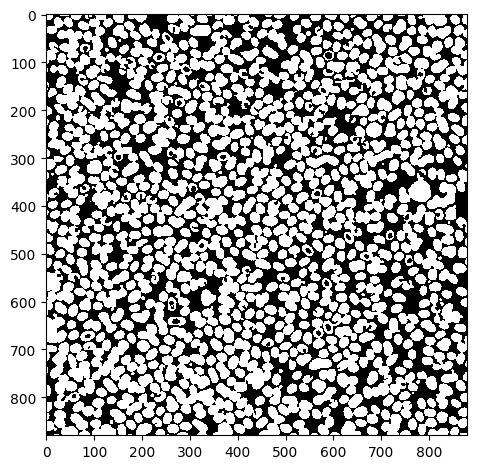

In [8]:
# Invertimos la imagen de forma que las células ahora sean blancas y el fondo negro para empezar a contar y diferenciarlas
inverted_mask = ~binary_mask

io.imshow(inverted_mask)
io.show()



Number of circles: 1684


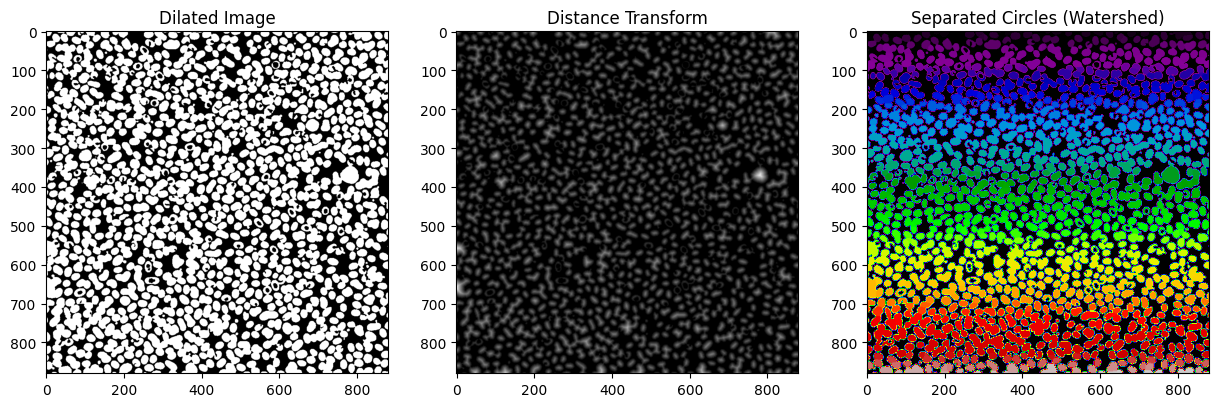

In [9]:
from skimage import io, morphology, segmentation, measure, filters
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

#Transformada de distancia
distance = ndi.distance_transform_edt(inverted_mask)

#Filtro gausiano para mejorar el mapa de distancia, y ajustamos sigma para determinar el nivel de suavizado del mapa
smoothed_distance = filters.gaussian(distance, sigma=1)  # Ajustamos sigma dependiendo de la separación entre células

# local maxima (marcadores)
local_maxi = morphology.local_maxima(smoothed_distance)

# Labelling de marcadores
markers, _ = ndi.label(local_maxi)

# Algoritmo watershed
labels = segmentation.watershed(-distance, markers, mask=inverted_mask)

# número de marcadores únicos (excluyendo el fondo, label 0)
num_circles = len(np.unique(labels)) - 1  # Subtract 1 to exclude background

print(f"Number of circles: {num_circles}")  #necesitamos el número de células calculado

# erosion and dilation on the markers para refinarlos ajustando el tamaño del disco
# Erosión de la imagen para mejorar el solapamiento antes de watershed
eroded_image = morphology.erosion(inverted_mask, morphology.disk(3))  # Ajustamos el tamaño del disco

# Dilatamos los marcadores
dilated_markers = morphology.dilation(markers, morphology.disk(3))  # Ajustamos el tamaño del disco

# Resultados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
ax[0].imshow(inverted_mask, cmap='gray')
ax[0].set_title('Dilated Image')

# Distance transform
ax[1].imshow(distance, cmap='gray')
ax[1].set_title('Distance Transform')

# Resultados
ax[2].imshow(labels, cmap='nipy_spectral')
ax[2].set_title('Separated Circles (Watershed)')

plt.show()


Se estima un mayor número de células de lo esperado (esperado: 1500) creemos que debido a que aún quedan huecos en las células. Como se puede observar en la comprobación al final del código en la que se trata de implementar el watershed con la imagen inicial con los huecos en las células, al aplicar watershed en circunferencias detecta más objetos de los existentes. Es por ello que decidimos aplicar apertura y erosiones y dilatación por separado para tratar de obtener un mayor número de células completas o rellenas.

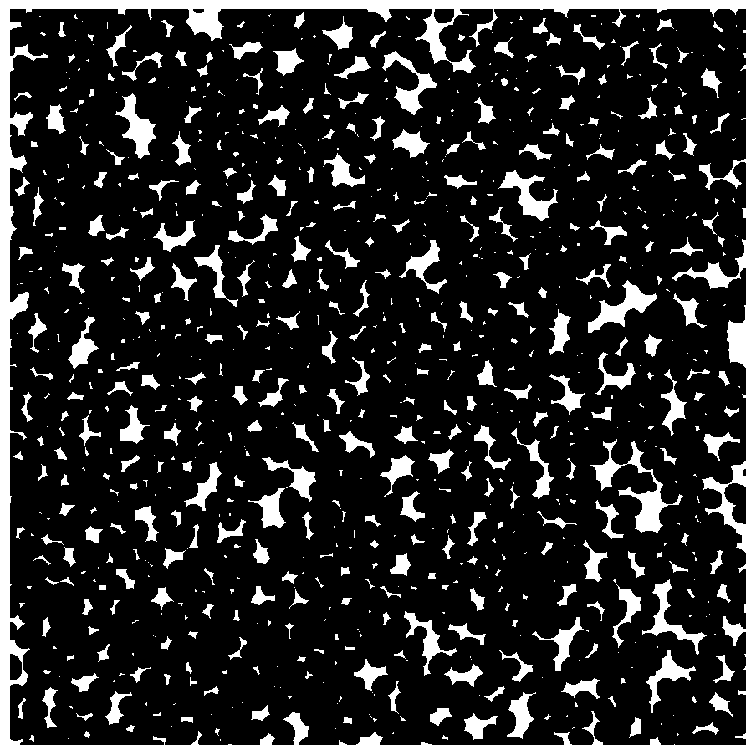

In [16]:
#PRUEBA. Probamos a erosionar las zonas blancas, las resultantes del paso anterior, para terminar de eliminar los huecos usando geometría circular.

import matplotlib.pyplot as plt
from skimage import io
from skimage.morphology import erosion, disk

# Aquí va tu código para cargar y procesar la imagen (binary_mask_cleaned)...

# Crear un elemento estructurante circular (ajustar el radio según el tamaño de los círculos)
selem = disk(3.7)  # El número 2 representa el radio del disco. Ajustar según sea necesario.

# Aplicar erosión solo a las áreas blancas (círculos) en la máscara binaria
binary_mask_eroded = erosion(binary_mask_cleaned, selem)

# Mostrar la máscara binaria erosionada (donde solo los círculos blancos son erosionados)
plt.figure(figsize=(8, 8))
io.imshow(binary_mask_eroded, cmap='gray')
plt.axis('off')
plt.show()

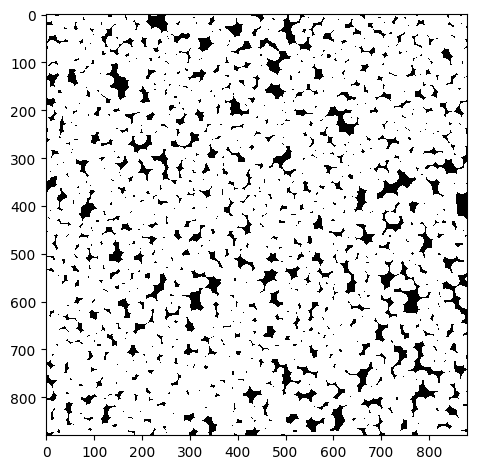

In [17]:
#Se invierte de blanco a negro con binary_mask_eroded

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
from skimage import io
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk
import numpy as np
from skimage.measure import find_contours
from skimage.draw import polygon
from skimage.morphology import erosion, disk
from skimage.morphology import opening, disk
from skimage.morphology import dilation, disk
from skimage.morphology import dilation, disk, erosion

# Invierte la máscara erosionada (blanco a negro, negro a blanco)
inverted_binary_mask_eroded = ~binary_mask_eroded

# Mostrar la máscara invertida
io.imshow(inverted_binary_mask_eroded)
io.show()


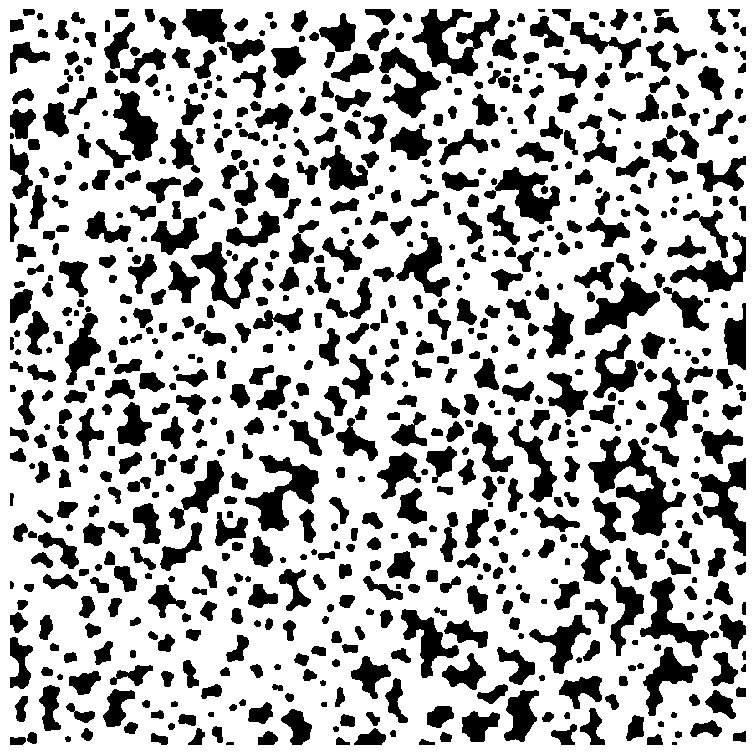

In [18]:
# prompt: erosiona los círculos de la imagen

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
from skimage import io
from skimage.filters import gaussian
from skimage.morphology import remove_small_objects, disk
import numpy as np
from skimage.measure import find_contours
from skimage.draw import polygon
from skimage.morphology import erosion, disk
from skimage.morphology import opening, disk
from skimage.morphology import dilation, disk
from skimage.morphology import dilation, disk, erosion

# Se crea un elemento estructurante circular (y se ajusta el radio según el tamaño de los círculos)
selem = disk(3.7)  # El número 2 representa el radio del disco y ha sido ajustado. Nota: números muy pequeños pueden implicar que la forma del disco no es realmente un disco o círculo

# Se aplica erosión solo a las áreas blancas (círculos) en la máscara binaria
binary_mask_eroded = erosion(inverted_binary_mask_eroded, selem)

# Se muestra la máscara binaria erosionada (donde solo los círculos blancos son erosionados)
plt.figure(figsize=(8, 8))
io.imshow(binary_mask_eroded, cmap='gray')
plt.axis('off')
plt.show()


Number of circles: 1478


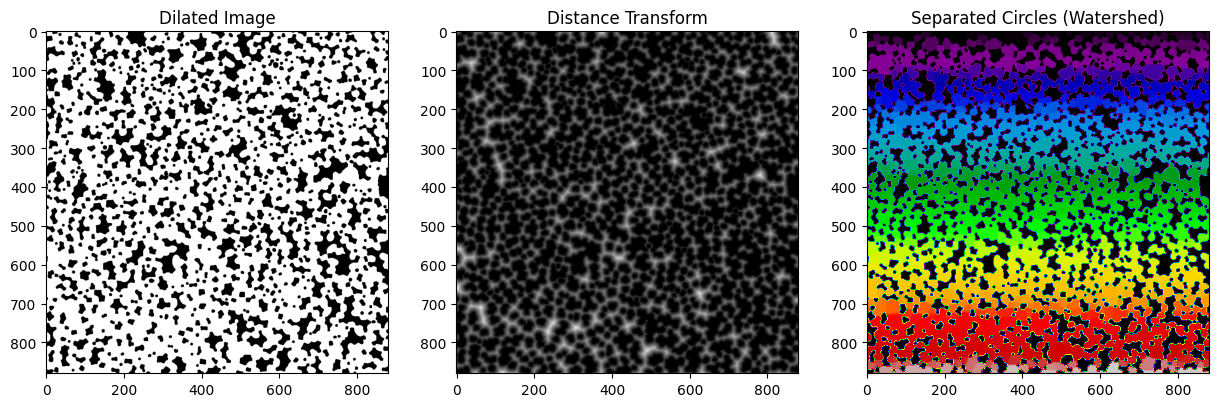

In [19]:
from skimage import io, morphology, segmentation, measure, filters
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

#Distance transform
distance = ndi.distance_transform_edt(binary_mask_eroded)

# Filtro Gausiano para suavizar el mapa de distancia (y se ajusta sigma para ajustar el nivel de suavizado)
smoothed_distance = filters.gaussian(distance, sigma=0.75)  # Se ajusta sigma para una mejor separación

# local maxima (marcadores)
local_maxi = morphology.local_maxima(smoothed_distance)

# Labelling de los marcadores
markers, _ = ndi.label(local_maxi)

# Watershed algoritmo
labels = segmentation.watershed(-distance, markers, mask=binary_mask_eroded)

# Número de etiquetas únicas, excluyendo el fondo ()number of unique labels (excluding the background, label 0)
num_circles = len(np.unique(labels)) - 1  # Subtract 1 to exclude background

print(f"Number of circles: {num_circles}")

# erosion y dilatación en los marcadores para refinarlos
# Erosión de la imagen dilatada para tratar de separar objeros solapados antes del algoritmo watershed
eroded_image = morphology.erosion(binary_mask_eroded, morphology.disk(3))  # Ajustar el tamaño del disco

# Dilatación de los marcadores
dilated_markers = morphology.dilation(markers, morphology.disk(3))  # Ajustaría el tamaño del disco

# resultados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Imagen original
ax[0].imshow(binary_mask_eroded, cmap='gray')
ax[0].set_title('Dilated Image')

# Distance transform
ax[1].imshow(distance, cmap='gray')
ax[1].set_title('Distance Transform')

# Resultado de segmentación
ax[2].imshow(labels, cmap='nipy_spectral')
ax[2].set_title('Separated Circles (Watershed)')

plt.show()


Resultado final más aproximado al número que deberíamos obtener.

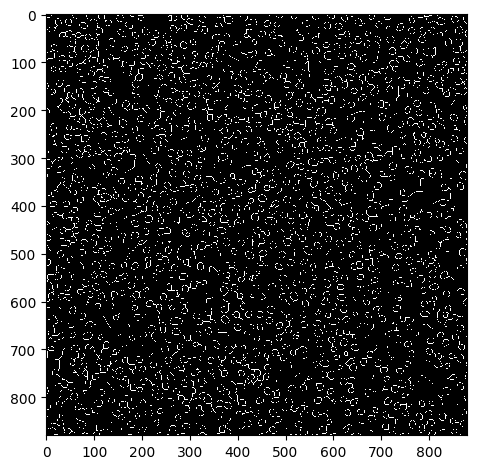

In [24]:
# Esqueleto de la imagen para observar si se obtenían elementos cerrados en forma de aproximación a circunferencias
#
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
from skimage import io
from skimage.filters import gaussian
from skimage.morphology import skeletonize
# Apply global binary thresholding
threshold_value = 0.85 #este valor ha sido ajustado
binary_mask2 = gray_image > threshold_value #Se queda con los valores de la imagen que están por encima del umbral
inverted_mask2 = ~binary_mask2
# Aplicamos la función
skeleton = skeletonize(inverted_mask2)

# observamos el resultado
io.imshow(skeleton)
io.show()


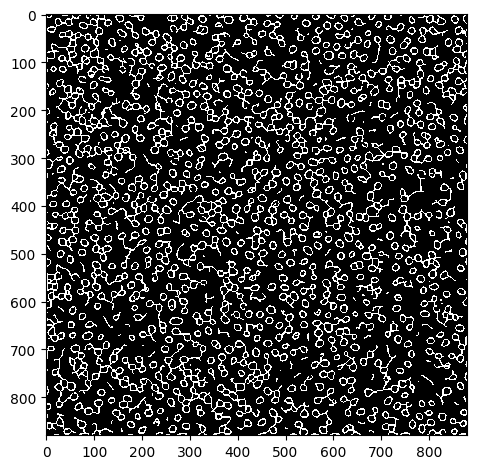

In [25]:
# dilatación

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
from skimage import io
from skimage.filters import gaussian
from skimage.morphology import skeletonize
from skimage.morphology import dilation, disk

# Definimos el elemento estructural para la dilatación
selem = disk(1)  # Adjust the radius for the desired dilation level

# se lleva a cabo la dilatación
dilated_skeleton = dilation(skeleton, selem)

# vemos el resultado
io.imshow(dilated_skeleton)
io.show()


<ipython-input-19-ee0f2ca4f9bc>:26: RuntimeWarning: divide by zero encountered in scalar divide
  y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
<ipython-input-19-ee0f2ca4f9bc>:27: RuntimeWarning: divide by zero encountered in scalar divide
  y1 = (dist - dilated_skeleton.shape[1] * np.cos(angle)) / np.sin(angle)


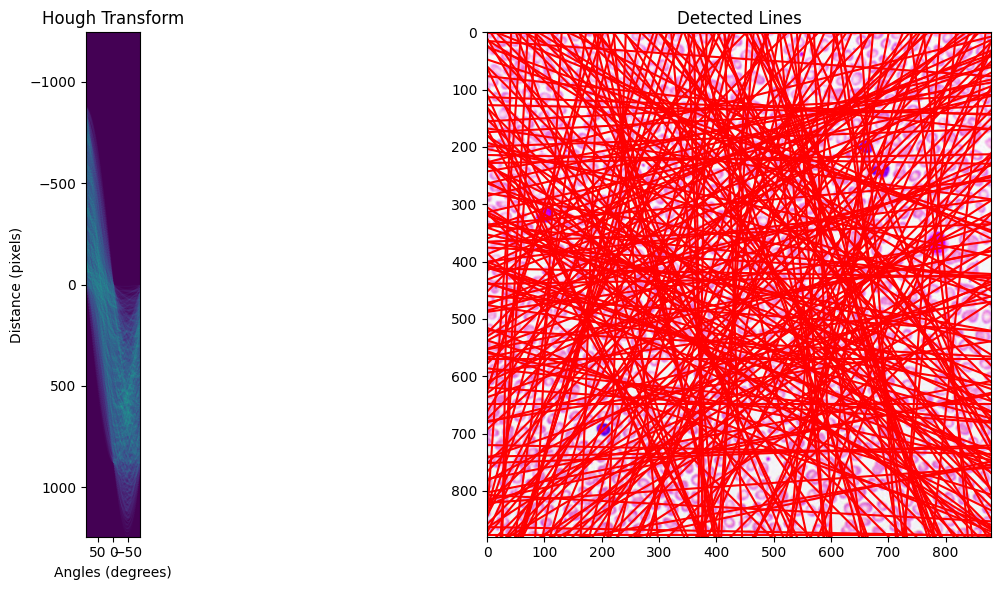

In [ ]:
# prompt: aplica la transformada de hough

import numpy as np
from skimage.transform import hough_line, hough_line_peaks
import matplotlib.pyplot as plt

# Aplicamos la transformada de Hough para detección de líneas para probar los resultados
hspace, angles, distances = hough_line(dilated_skeleton)

# Encontramos los peaks para obtener las líneas prominentes
_, angles_peaks, dist_peaks = hough_line_peaks(hspace, angles, distances)

# Imprimimos el rseultado por pantalla
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

ax[0].imshow(hspace, extent=[np.rad2deg(angles[-1]), np.rad2deg(angles[0]), distances[-1], distances[0]], aspect=1/1.5)
ax[0].set_xlabel('Angles (degrees)')
ax[0].set_ylabel('Distance (pixels)')
ax[0].set_title('Hough Transform')

ax[1].imshow(img)  # objetivo de imprimir la imagen original
for _, angle, dist in zip(*hough_line_peaks(hspace, angles, distances)):
  y0 = (dist - 0 * np.cos(angle)) / np.sin(angle)
  y1 = (dist - dilated_skeleton.shape[1] * np.cos(angle)) / np.sin(angle)
  ax[1].plot((0, dilated_skeleton.shape[1]), (y0, y1), '-r')
ax[1].set_xlim((0, dilated_skeleton.shape[1]))
ax[1].set_ylim((dilated_skeleton.shape[0], 0))
ax[1].set_title('Detected Lines')

plt.tight_layout()
plt.show()


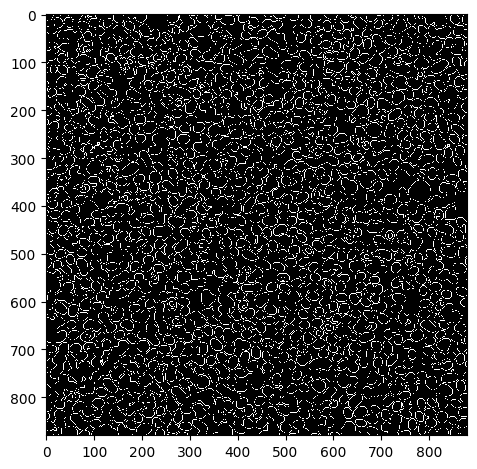

In [ ]:
#detección de bordes

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
from skimage import io
from skimage.filters import gaussian

from skimage.feature import canny
# El objetivo de este notebook es contar de manera automática los diferentes elementos (células) que aparecen en las dos imágenes proporcionadas
# Para leer y cargar la imagen
# Importar las librerías necesarias

blurred_image = gaussian(inverted_mask, sigma=1) # Apply Gaussian blur with sigma=1, adjust if needed

# Aplicamos la detección de bordes Canny
edges = canny(blurred_image, sigma=0)  # Ajustamos sigma

# Vemos los bordes
io.imshow(edges)
io.show()


Number of circles: 2447


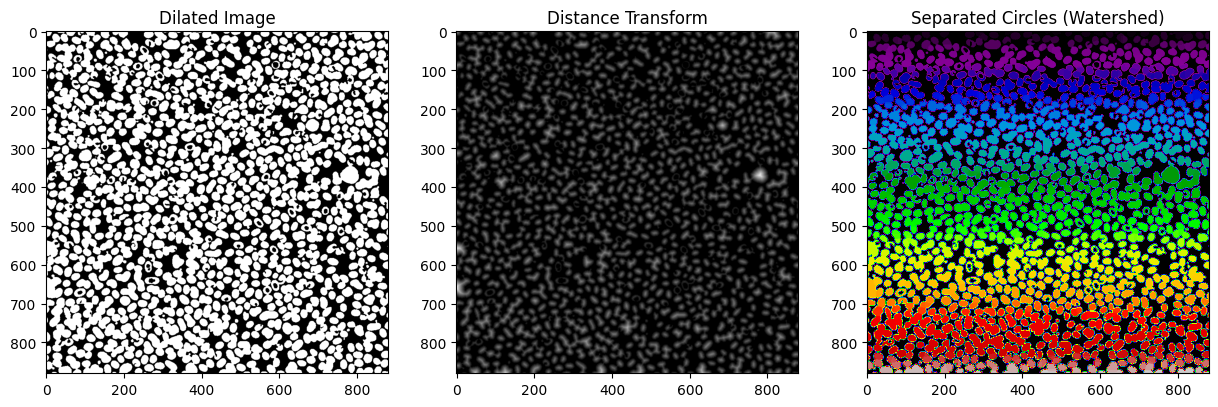

In [ ]:
import numpy as np
from skimage import io, morphology, measure, segmentation, filters
from scipy import ndimage as ndi
import matplotlib.pyplot as plt

# computamos la transformada de distancia
distance = ndi.distance_transform_edt(inverted_mask)

# encontramos los máximos locales que serán los marcadores para el algoritmo watershed
local_maxi = morphology.local_maxima(distance)

# labeling de marcadores
markers, _ = ndi.label(local_maxi)

# algoritmo watershed
labels = segmentation.watershed(-distance, markers, mask=inverted_mask)

# Paso 5: Contamos el número de marcadores únicos (excluyendo el fondo, label 0)
num_circles = len(np.unique(labels)) - 1  # Subtract 1 to exclude background

print(f"Number of circles: {num_circles}")

# Paso 6: vemos los resultados
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# Imagen dilatada original
ax[0].imshow(inverted_mask, cmap='gray')
ax[0].set_title('Dilated Image')

# Transformada de la distancia
ax[1].imshow(distance, cmap='gray')
ax[1].set_title('Distance Transform')

# Resultado de la segmentación
ax[2].imshow(labels, cmap='nipy_spectral')
ax[2].set_title('Separated Circles (Watershed)')

plt.show()

Para ver cómo funciona watershed cuando las células todavía tienen círculos blancos en su interior. (Funciona mal):

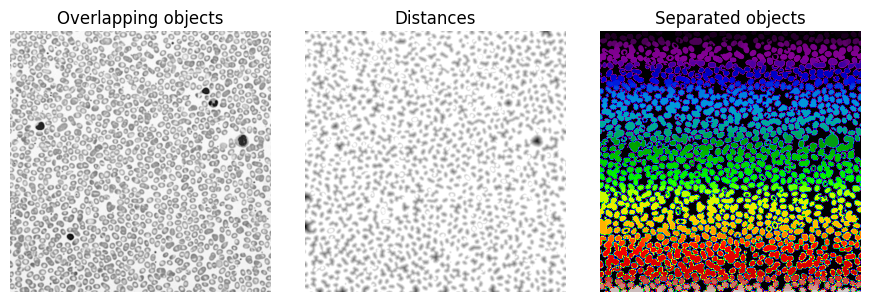

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters, morphology, segmentation, measure
from skimage import io
from scipy import ndimage
import numpy as np
# Import the peak_local_max function directly from skimage.feature
from skimage.feature import peak_local_max

# Transformada de distancia en la máscara invertida
distance = ndimage.distance_transform_edt(inverted_mask)

# Encontramos los máximos locales en la transformada de distancia
local_maxi = peak_local_max(distance, footprint=np.ones((3, 3)),
                                      labels=inverted_mask)  # Remove 'indices' argument

# Creamos un array de marcadores con el mismo tamaño que la imagen original. Los marcadores son la base para separar las regiones de segmentación
markers = np.zeros_like(inverted_mask, dtype=bool)
markers[tuple(local_maxi.T)] = True

# Para el labeling of markers en el "marker array" para la creación de marcadores únicos que usar para watershed
markers = measure.label(markers)

# segmentación con watershed
labels_ws = segmentation.watershed(-distance, markers, mask=inverted_mask)

# vemos el resultado por pantalla
fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

#para poner la primera imagen
ax[0].imshow(gray_image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')

#para poner la imagen con las distancias
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')

#para observar la imagen final y cómo ha actuado el watershed
ax[2].imshow(labels_ws, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

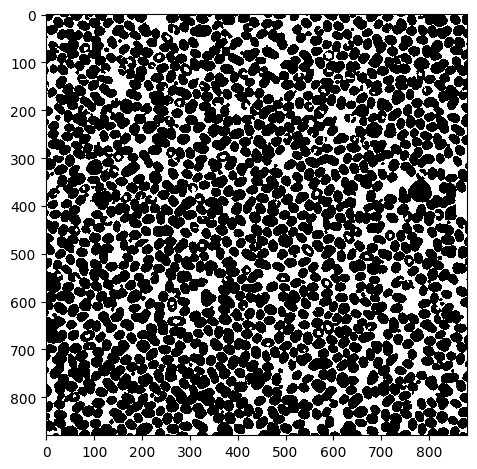

In [ ]:
#NO FUNCIONA
from skimage import morphology

# erosion
eroded_image = morphology.erosion(binary_mask, morphology.disk(1))  # Adjust disk size as needed

# Display the eroded image
io.imshow(eroded_image)
io.show()


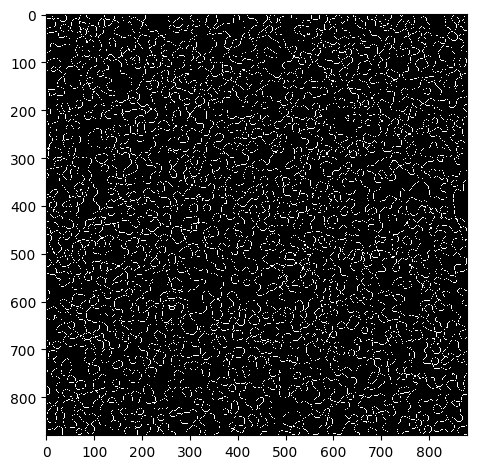

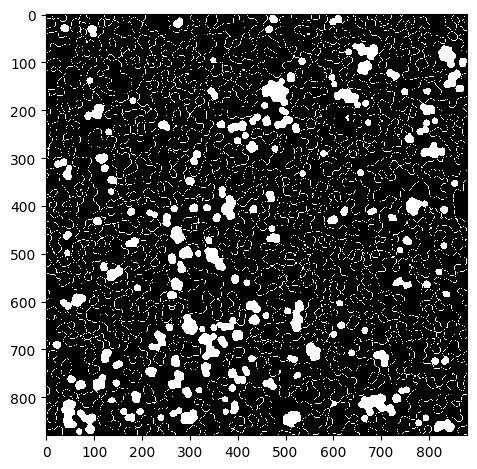

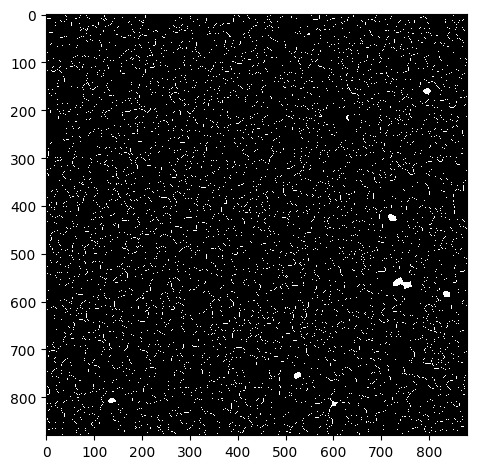

In [28]:
#Detección y rellenado de bordes

# prompt: detectar los bordes y rellenarlo

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color
from skimage import color, filters
import cv2
from skimage import io
from skimage import img_as_ubyte


# Detectar los bordes usando Canny
edges = cv2.Canny(img_as_ubyte(eroded_image), 40, 90)  # Ajusta los umbrales según sea necesario

io.imshow(edges)
io.show()

# Rellenar los bordes detectados
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Crear una máscara para rellenar los contornos
mask = np.zeros_like(edges)

# Dibujar los contornos rellenos en la máscara
cv2.drawContours(mask, contours, -1, (255), thickness=cv2.FILLED)

io.imshow(mask)
io.show()

# Mostrar la imagen con los contornos rellenados
filled_image = cv2.bitwise_and(img_as_ubyte(eroded_image), img_as_ubyte(eroded_image), mask=mask)

io.imshow(filled_image)
io.show()

Círculo no relleno detectado en (775, 186) con radio 10
Círculo no relleno detectado en (39, 699) con radio 12
Círculo no relleno detectado en (137, 413) con radio 10
Círculo no relleno detectado en (502, 349) con radio 10
Círculo no relleno detectado en (724, 78) con radio 10
Círculo no relleno detectado en (120, 632) con radio 10
Círculo no relleno detectado en (234, 454) con radio 10
Círculo no relleno detectado en (110, 361) con radio 10
Círculo no relleno detectado en (197, 259) con radio 10
Círculo no relleno detectado en (464, 177) con radio 10
Círculo no relleno detectado en (795, 160) con radio 10
Círculo no relleno detectado en (344, 724) con radio 10
Círculo no relleno detectado en (539, 816) con radio 10
Círculo no relleno detectado en (711, 863) con radio 10
Círculo no relleno detectado en (28, 643) con radio 10
Círculo no relleno detectado en (81, 561) con radio 10
Círculo no relleno detectado en (855, 11) con radio 10
Círculo no relleno detectado en (487, 675) con radio 

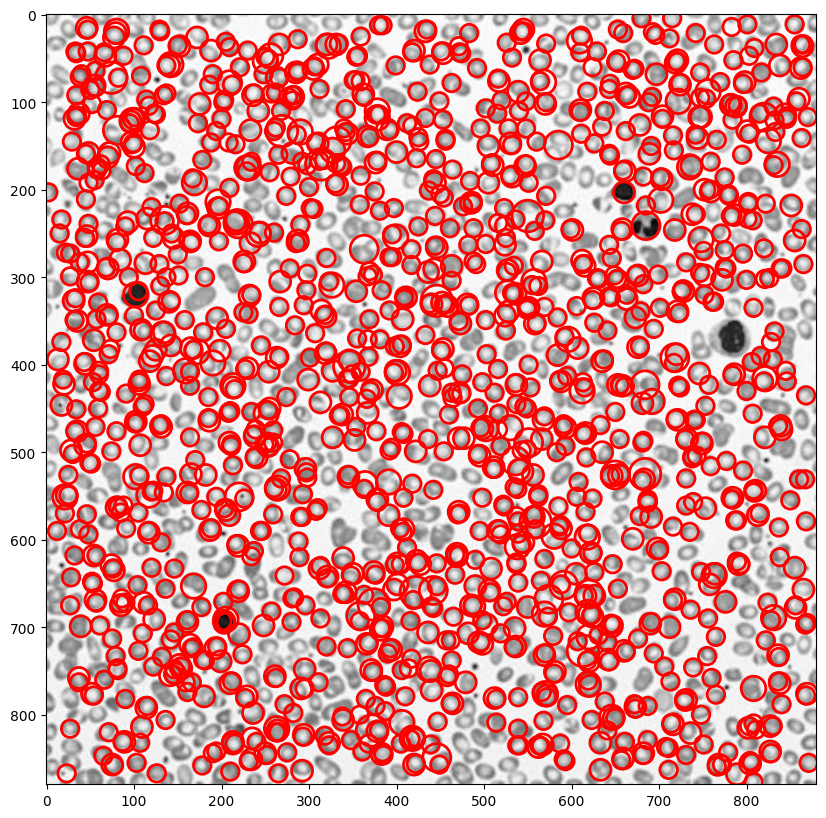

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color, feature
from skimage.draw import disk
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.feature import canny
from skimage import img_as_ubyte


# 1- Aplicamos el filtro Canny
edges = canny(gray_image, sigma=2)  # Cambiamos sigma pero aún así no daba buenos resultados

# 2- Aplicamos la Transformada de Hough para círculos
hough_radii = np.arange(10, 100, 2)  # modificamos el radio de los círculos
hough_res = hough_circle(edges, hough_radii)

# 3- Obtenemos los círculos detectados
accum, cx, cy, radii = hough_circle_peaks(hough_res, hough_radii, total_num_peaks=1440) #Problema: para ello necesitábamos saber previamente el número de círculos

# 4- Dibujamos los círculos detectados en la imagen original
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.imshow(gray_image, cmap='gray')

# 5- Clasificamos si están rellenos o no
for center_y, center_x, radius in zip(cy, cx, radii):
    # Dibujamos círculo
    circle = plt.Circle((center_x, center_y), radius, color='red', fill=False, linewidth=2)
    ax.add_patch(circle)

    # Verificamos si está relleno o no
    rr, cc = disk((center_y, center_x), radius, shape=gray_image.shape)
    # Calculamos el promedio de los valores dentro del círculo
    if np.mean(gray_image[rr, cc]) < 0.5:  # Puedes ajustar este umbral
        print(f"Círculo relleno detectado en ({center_x}, {center_y}) con radio {radius}")
    else:
        print(f"Círculo no relleno detectado en ({center_x}, {center_y}) con radio {radius}")

plt.show()